In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import warnings


from scipy.stats import norm, binom

warnings.filterwarnings('ignore')

### Set up for code 7.25 onwards

In [2]:
# number of plants
N = 100

# initial heights
h0 = norm.rvs(loc=10, scale=2, size=N)

# assign treatment and fungus growth
treatment = np.zeros(N)
treatment[N//2:] = 1

# there is a 10% chance of fungus growth for the plants that have been treated; and 50% for those that haven't
fungus = binom.rvs(n=1, p=0.5 - 0.4 * treatment, loc=0, size=N)

# the mean height for plants without fungus is 10 + 5 = 15; for those with fungus: 10 + 2 = 12
h1 = h0 + norm.rvs(loc=5 - 3 * fungus, scale=1, size=N)

df = pd.DataFrame({'h0': h0, 'h1': h1, 'treatment': treatment, 'fungus': fungus})
df.describe([0.055, 0.945])

,h0,h1,treatment,fungus
count,100.000000,100.000000,100.000000,100.000000
mean,9.955211,13.779175,0.500000,0.360000
std,1.888951,2.491715,0.502519,0.482418
min,5.451161,6.891129,0.000000,0.000000
5.5%,7.185326,9.604864,0.000000,0.000000
50%,9.764998,13.710347,0.500000,0.000000
94.5%,13.036594,17.719956,1.000000,1.000000
max,14.395075,19.079618,1.000000,1.000000


# Causal Diagram of Fungal Growth Simulation

$$
    H_0 \rightarrow H_1 \leftarrow F \leftarrow T
$$


# Models M6.6, M6.7, M6.8 

### Model M.6.6 

$$
\begin{align*}
    h_{1 i} & \sim N(\mu_i, \sigma) \\
    \mu_i   & = h_{0 i} \times p \\
     p      & \sim \text{LogNormal}(0, 0.25)
\end{align*}
$$

### Model M6.7

$$
\begin{align*}
    h_{1 i} & \sim N(\mu_i, \sigma) \\
    \mu_i   & = h_{0 i} \times p \\
    p       & = \alpha + \beta_T \cdot T_i + \beta_F \cdot F_i \\
    \alpha  & \sim \text{LogNormal}(0, 0.25) \\
    \beta_T & \sim N(0, 0.5) \\
    \beta_F & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$


### Model M6.8

$$
\begin{align*}
    h_{1 i} & \sim N(\mu_i, \sigma) \\
    \mu_i   & = h_{0 i} \times p \\
    p       & = \alpha + \beta_T \cdot T_i \\
    \alpha  & \sim \text{LogNormal}(0, 0.25) \\
    \beta_T & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

In [3]:
with pm.Model() as m_6_6:
    p = pm.Lognormal('p', mu=0, sigma=0.25)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', df['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df['h1'])
    
    trace_6_6 = pm.sample(2000, tune=2000)
    
with pm.Model() as m_6_7:
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    b_T = pm.Normal('b_T', mu=0, sigma=0.5)
    b_F = pm.Normal('b_F', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    p = a + b_T * df['treatment'] + b_F * df['fungus']
    mu = pm.Deterministic('mu', df['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df['h1'])
    
    trace_6_7 = pm.sample(2000, tune=2000)
    
with pm.Model() as m_6_8:
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    b_T = pm.Normal('b_T', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    p = a + b_T * df['treatment']
    mu = pm.Deterministic('mu', df['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df['h1'])
    
    trace_6_8 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_F, b_T, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_T, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.


### Code. 7.25

In [4]:
az.waic(trace_6_7, m_6_7, scale='deviance')

Computed from 8000 by 100 log-likelihood matrix

              Estimate       SE
deviance_waic   328.46    11.96
p_waic            3.43        -

### Code 7.26

In [5]:
trace_dict = {'m_6_6': trace_6_6, 
              'm_6_7': trace_6_7, 
              'm_6_8': trace_6_8}

compare_dict = az.compare(trace_dict, ic='waic', scale='deviance')
compare_dict

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_6_7,0,328.460192,3.433410,0.000000,1.000000e+00,11.961350,0.000000,False,deviance
m_6_8,1,387.685050,3.202372,59.224858,0.000000e+00,14.618257,13.739865,True,deviance
m_6_6,2,413.412438,1.691511,84.952246,2.867995e-11,11.239561,12.296297,False,deviance


### Explanation of column names

* p_waic: the WAIC penalty
* d_waic: the difference of each WAIC from best model (the one with lowest WAIC value)
* weight: the relative weight of each model. This can be interpreted as the probability of each model given the data.
* se: the standard error of the WAIC estimates
* dse: the standard error of the difference between the model and the top-ranked model.

## Computing the dse manually

### Code 7.27

In [6]:
waic_6_7 = az.waic(trace_6_7, pointwise=True, scale='deviance')
waic_6_8 = az.waic(trace_6_8, pointwise=True, scale='deviance')

diff = waic_6_7.waic_i - waic_6_8.waic_i
n = len(diff)

dse = np.sqrt(n * np.var(diff)).values
dse

array(13.73986498)

In [7]:
from scipy.stats import norm


# the 99% interval for a standard normal

norm.ppf(q=0.995, loc=0, scale=1)

2.5758293035489004

### Code 7.28

In [8]:
waic_diff = waic_6_8.waic - waic_6_7.waic

waic_diff + np.array([-1, 1]) * dse * 2.6

array([23.50120912, 94.94850701])

### Code 7.29

<AxesSubplot:xlabel='Deviance'>

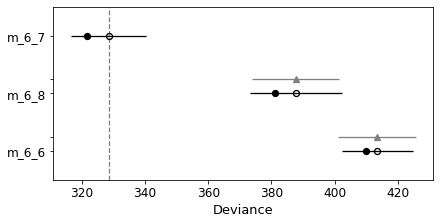

In [9]:
az.plot_compare(compare_dict)

In [10]:
az.summary(trace_6_8, var_names=['a', 'b_T', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.275,0.024,1.232,1.320,0.000,0.000,3705.0,3746.0,1.0
b_T,0.185,0.034,0.125,0.251,0.001,0.000,3797.0,4545.0,1.0
sigma,1.650,0.120,1.430,1.869,0.002,0.001,4798.0,3727.0,1.0


### Code 7.30

In [11]:
waic_6_6 = az.waic(trace_6_6, pointwise=True, scale='deviance')

diff_m6_6_m6_8 = (waic_6_6.waic_i - waic_6_8.waic_i).values

n = len(diff_m6_6_m6_8)
np.sqrt(n * np.var(diff_m6_6_m6_8))

11.048871281118211

### Code 7.31

In [12]:
waic_6_6 = az.waic(trace_6_6, pointwise=True, scale='deviance')
waic_6_7 = az.waic(trace_6_7, pointwise=True, scale='deviance')
waic_6_8 = az.waic(trace_6_8, pointwise=True, scale='deviance')

waic_list = [waic_6_6, waic_6_7, waic_6_8]
dse_matrix = np.zeros((3, 3))

start = 0

while start < len(waic_list):
    for w in range(start, len(waic_list)):
        d = (waic_list[start].waic_i - waic_list[w].waic_i).values
        n = len(d)
        dse_matrix[start, w] = np.sqrt(n * np.var(d))
    start += 1

i_lower = np.tril_indices(3, -1)
dse_matrix[i_lower] = dse_matrix.T[i_lower]

dse_df = pd.DataFrame(dse_matrix, columns=['m_6_6', 'm_6_7', 'm_6_8'], index=['m_6_6', 'm_6_7', 'm_6_8'])

In [13]:
dse_df

,m_6_6,m_6_7,m_6_8
m_6_6,0.000000,12.296297,11.048871
m_6_7,12.296297,0.000000,13.739865
m_6_8,11.048871,13.739865,0.000000


In [14]:
def dse_compare(trace_dict):
    waic_list = []
    columns = []
    
    for model_name, trace in trace_dict.items():
        waic = az.waic(trace, pointwise=True, scale='deviance')
        waic_list.append(waic)
        columns.append(model_name)
        
    num_models = len(columns) 
    dse_matrix = np.zeros((num_models, num_models))

    start = 0

    while start < len(waic_list):
        for w in range(start, len(waic_list)):
            d = (waic_list[start].waic_i - waic_list[w].waic_i).values
            n = len(d)
            dse_matrix[start, w] = np.sqrt(n * np.var(d))
        start += 1

    i_lower = np.tril_indices(num_models, -1)
    dse_matrix[i_lower] = dse_matrix.T[i_lower]

    dse_df = pd.DataFrame(dse_matrix, columns=columns, index=columns)
    return dse_df

In [15]:
dse_compare(trace_dict)

,m_6_6,m_6_7,m_6_8
m_6_6,0.000000,12.296297,11.048871
m_6_7,12.296297,0.000000,13.739865
m_6_8,11.048871,13.739865,0.000000
